In [1]:
# 目的: 直接讀取 2023_3DUNET_Model_INPUT 資料夾中的 DLG_INPUT.npy & LABEL_INPUT.npy檔案進行模型訓練

In [2]:
# Step1 導入套件
import tensorflow as tf
#import keras
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 設定不要佔滿顯存
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import segmentation_models_3D as sm
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc  # 引入垃圾回收模組
# 設定訓練只用 float16 降低記憶體使用量
#tf.keras.backend.set_floatx('float16')
tf.keras.backend.floatx()

2.8.0
2.8.0
Segmentation Models: using `tf.keras` framework.


'float32'

In [3]:
# Step1_1 先設定這次要切割的大腦腦區，後續會用到"_MB.ome" 末檔案名稱
seg_target = 'CAL'
seg_target_small = 'cal'

In [4]:
# Step2 讀取訓練用檔案，設定訓練前的參數 ==========為了要節省記憶體(先處理mask轉換成 one hot encode) 
train_mask = np.load('2023_3DUNET_Model_INPUT/LABEL_INPUT.npy')
# 設定總個分類數量 (目前只有背景+MB)
n_classes=2
train_mask = np.expand_dims(train_mask, axis=4)
# 應該是轉換one hot encode
train_mask_cat = to_categorical(train_mask, num_classes=n_classes)
print('Finish: one hot excode')
del train_mask
gc.collect()  # 先觸發垃圾回收
# 上面處理好 train_mask 經one hot encode 成 train_mask_cat
# 接續讀取 train_img
train_img = np.load('2023_3DUNET_Model_INPUT/DLG_INPUT.npy')
train_img = np.stack((train_img,)*1, axis=-1)# ==========此處可以拓展成3通道或是維持1通道
print('Finish: stack & expand_dim')
# 分成訓練跟驗證
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)
# ====================此版本沒有使用  input_B_Brain_DLG_2 input_B_Brain_LABEL_2 進行訓練===========
del train_img
del train_mask_cat
gc.collect()  # 先觸發垃圾回收

Finish: one hot excode
Finish: stack & expand_dim


11

# 原本先讀取 train_img & train_mask的版本 會多占用8GB記憶體
# Step2 讀取訓練用檔案，設定訓練前的參數 ==========為了要節省記憶體(先處理mask轉換成 one hot encode) 
train_img = np.load('2023_3DUNET_Model_INPUT/DLG_INPUT.npy')
train_mask = np.load('2023_3DUNET_Model_INPUT/LABEL_INPUT.npy')
# 設定總個分類數量 (目前只有背景+MB)
n_classes=2
train_img = np.stack((train_img,)*1, axis=-1)# ==========此處可以拓展成3通道或是維持1通道
train_mask = np.expand_dims(train_mask, axis=4)
print('Finish: stack & expand_dim')
# 應該是轉換one hot encode
train_mask_cat = to_categorical(train_mask, num_classes=n_classes)
print('Finish: one hot excode')
del train_mask
gc.collect()  # 先觸發垃圾回收
# 分成訓練跟驗證
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)
# ====================此版本沒有使用  input_B_Brain_DLG_2 input_B_Brain_LABEL_2 進行訓練===========
del train_img
del train_mask_cat
gc.collect()  # 先觸發垃圾回收

In [4]:
# Step3 設定 loss function
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [5]:
# Step4 定義模型參數
Step_of_slide = 20 # 滑動步數
Size_of_cube = 128 # 長寬尺寸
#Define parameters for our model.
# 這是有使用預訓練權重 = imagenet
# encoder_weights = 'imagenet'
# 這裡使用灰階作為輸入影像，不要使用預先訓練權重
encoder_weights = None
BACKBONE = 'resnet50'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = Size_of_cube#Size_of_cube =64 or 128
n_classes = 2
channels=1 # 1 or 3
# 這裡測試設定通道1即可
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.4, 0.6]))# 這裡要記得對應類別數量修改，同時應該將背景權重調低
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [6]:
# Step5 準備3D UNET骨幹
preprocess_input = sm.get_preprocessing(BACKBONE)
# 使用 preprocess_input 函數處理輸入端的3D圖
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)
# 似乎是轉換成float32，原本是uint8
# 查看訓練跟驗證集shape，以及資料型態，和查看 get_preprocessing 標準化後的DLG最大值
print(X_train_prep.shape)
print(X_test_prep.shape)
print(X_train_prep.dtype)
print(X_test_prep.dtype)
print(np.max(X_train_prep))
print(np.max(X_test_prep))

(2008, 64, 128, 128, 1)
(224, 64, 128, 128, 1)
float64
float64
255.0
255.0


In [7]:
# Step6 定義模型框架
#Define the model. Here we use Unet but we can also use other model architectures from the library.
# 這裡要注意輸入shape 可以是(64x64x64x3) or (64x128x128x3)
model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(64, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

2023-09-19 10:51:06.591145: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 10:51:07.190256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 64, 128, 12  0           []                               
                                8, 1)]                                                            
                                                                                                  
 bn_data (BatchNormalization)   (None, 64, 128, 128  3           ['data[0][0]']                   
                                , 1)                                                              
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, 70, 134, 134  0          ['bn_data[0][0]']                
                                , 1)                                                        

                                                                                                  
 stage1_unit2_bn3 (BatchNormali  (None, 16, 32, 32,   256        ['stage1_unit2_conv2[0][0]']     
 zation)                        64)                                                               
                                                                                                  
 stage1_unit2_relu3 (Activation  (None, 16, 32, 32,   0          ['stage1_unit2_bn3[0][0]']       
 )                              64)                                                               
                                                                                                  
 stage1_unit2_conv3 (Conv3D)    (None, 16, 32, 32,   16384       ['stage1_unit2_relu3[0][0]']     
                                256)                                                              
                                                                                                  
 add_1 (Ad

 zation)                        12)                                                               
                                                                                                  
 stage2_unit2_relu1 (Activation  (None, 8, 16, 16, 5  0          ['stage2_unit2_bn1[0][0]']       
 )                              12)                                                               
                                                                                                  
 stage2_unit2_conv1 (Conv3D)    (None, 8, 16, 16, 1  65536       ['stage2_unit2_relu1[0][0]']     
                                28)                                                               
                                                                                                  
 stage2_unit2_bn2 (BatchNormali  (None, 8, 16, 16, 1  512        ['stage2_unit2_conv1[0][0]']     
 zation)                        28)                                                               
          

 stage2_unit4_conv2 (Conv3D)    (None, 8, 16, 16, 1  442368      ['zero_padding3d_8[0][0]']       
                                28)                                                               
                                                                                                  
 stage2_unit4_bn3 (BatchNormali  (None, 8, 16, 16, 1  512        ['stage2_unit4_conv2[0][0]']     
 zation)                        28)                                                               
                                                                                                  
 stage2_unit4_relu3 (Activation  (None, 8, 16, 16, 1  0          ['stage2_unit4_bn3[0][0]']       
 )                              28)                                                               
                                                                                                  
 stage2_unit4_conv3 (Conv3D)    (None, 8, 16, 16, 5  65536       ['stage2_unit4_relu3[0][0]']     
          

                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 4, 8, 8, 102  4096       ['add_8[0][0]']                  
 zation)                        4)                                                                
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, 4, 8, 8, 102  0          ['stage3_unit3_bn1[0][0]']       
 )                              4)                                                                
                                                                                                  
 stage3_unit3_conv1 (Conv3D)    (None, 4, 8, 8, 256  262144      ['stage3_unit3_relu1[0][0]']     
                                )                                                                 
                                                                                                  
 stage3_un

 3D)                            56)                                                               
                                                                                                  
 stage3_unit5_conv2 (Conv3D)    (None, 4, 8, 8, 256  1769472     ['zero_padding3d_13[0][0]']      
                                )                                                                 
                                                                                                  
 stage3_unit5_bn3 (BatchNormali  (None, 4, 8, 8, 256  1024       ['stage3_unit5_conv2[0][0]']     
 zation)                        )                                                                 
                                                                                                  
 stage3_unit5_relu3 (Activation  (None, 4, 8, 8, 256  0          ['stage3_unit5_bn3[0][0]']       
 )                              )                                                                 
          

 add_13 (Add)                   (None, 2, 4, 4, 204  0           ['stage4_unit1_conv3[0][0]',     
                                8)                                'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, 2, 4, 4, 204  8192       ['add_13[0][0]']                 
 zation)                        8)                                                                
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, 2, 4, 4, 204  0          ['stage4_unit2_bn1[0][0]']       
 )                              8)                                                                
                                                                                                  
 stage4_unit2_conv1 (Conv3D)    (None, 2, 4, 4, 512  1048576     ['stage4_unit2_relu1[0][0]']     
          

                                )                                                                 
                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, 4, 8, 8, 256  1024       ['decoder_stage0a_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage0a_relu (Activati  (None, 4, 8, 8, 256  0          ['decoder_stage0a_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_stage0b_conv (Conv3D)  (None, 4, 8, 8, 256  1769472     ['decoder_stage0a_relu[0][0]']   
                                )                                                                 
          

 decoder_stage3b_conv (Conv3D)  (None, 32, 64, 64,   27648       ['decoder_stage3a_relu[0][0]']   
                                32)                                                               
                                                                                                  
 decoder_stage3b_bn (BatchNorma  (None, 32, 64, 64,   128        ['decoder_stage3b_conv[0][0]']   
 lization)                      32)                                                               
                                                                                                  
 decoder_stage3b_relu (Activati  (None, 32, 64, 64,   0          ['decoder_stage3b_bn[0][0]']     
 on)                            32)                                                               
                                                                                                  
 decoder_stage4_upsampling (UpS  (None, 64, 128, 128  0          ['decoder_stage3b_relu[0][0]']   
 ampling3D

# Step6_1 查看模型框架圖
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True)

In [8]:
# Step7 訓練模型(新版會在訓練中保存最佳模型)
from keras.callbacks import ModelCheckpoint
# 創建一個回調函數，以保存最佳權重和架構
checkpoint = ModelCheckpoint(seg_target+'最佳模型/best_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
# 在fit()方法中添加回調函數
history = model.fit(X_train_prep,
                    y_train,
                    batch_size=2,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test_prep, y_test),
                    callbacks=[checkpoint])

Epoch 1/20


2023-09-19 10:51:33.573706: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:345] Cancel Transpose nodes around Pad: transpose_before=model_1/bn_data/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=model_1/zero_padding3d/Pad transpose_after=model_1/conv0/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/model_1/conv0/Conv3D/Conv3DBackpropFilterV2-0-TransposeNDHWCToNCDHW-LayoutOptimizer
2023-09-19 10:51:35.701569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


1004/1004 [==============================] - ETA: 0s - loss: 0.6875 - iou_score: 0.6921 - f1-score: 0.7376

2023-09-19 10:53:47.553843: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:345] Cancel Transpose nodes around Pad: transpose_before=model_1/bn_data/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=model_1/zero_padding3d/Pad transpose_after=model_1/conv0/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer


1004/1004 [==============================] - 144s 131ms/step - loss: 0.6875 - iou_score: 0.6921 - f1-score: 0.7376 - val_loss: 0.6280 - val_iou_score: 0.7557 - val_f1-score: 0.8077
Epoch 2/20
1004/1004 [==============================] - 126s 126ms/step - loss: 0.6271 - iou_score: 0.8121 - f1-score: 0.8502 - val_loss: 0.5978 - val_iou_score: 0.8894 - val_f1-score: 0.9324
Epoch 3/20
1004/1004 [==============================] - 126s 125ms/step - loss: 0.6158 - iou_score: 0.8665 - f1-score: 0.8995 - val_loss: 0.5926 - val_iou_score: 0.8946 - val_f1-score: 0.9353
Epoch 4/20
1004/1004 [==============================] - 126s 126ms/step - loss: 0.6089 - iou_score: 0.8736 - f1-score: 0.9069 - val_loss: 0.5854 - val_iou_score: 0.9173 - val_f1-score: 0.9513
Epoch 5/20
1004/1004 [==============================] - 126s 126ms/step - loss: 0.6097 - iou_score: 0.8727 - f1-score: 0.9047 - val_loss: 0.5826 - val_iou_score: 0.9216 - val_f1-score: 0.9550
Epoch 6/20
1004/1004 [=============================

# Step7 訓練模型(舊版單純執行20次)
#Fit the model
history=model.fit(X_train_prep, 
          y_train,
          batch_size=2, 
          epochs=20,
          verbose=1,
          validation_data=(X_test_prep, y_test))
# 1000,64,128,128,1 GPU使用22GB float32 (滑動步數=5) batch_size=2
# 1895,64,128,128,1 GPU使用40GB float32 (滑動步數=5) batch_size=2
# 315,64,128,128,1 GPU使用12.7GB float32 (滑動步數=10) batch_size=2
# 472,64,128,128,1 GPU使用20GB float32 (滑動步數=10) batch_size=8
# 97,64,128,128,1 GPU使用 9.7GB float32 (滑動步數=20) batch_size=2
# 正式版 (907, 64, 128, 128, 1) GPU使用??GB (滑動步數=20) batch_size=2

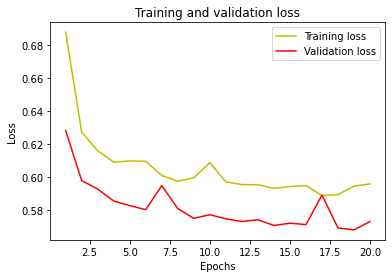

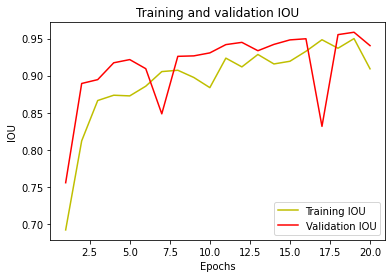

In [9]:
# Step8 查看訓練過程
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#Save model for future use
model.save('正式版_CAL腦區_3D_model_resnet50_20epochs_64_128_128_1_Neuropils.h5')

In [ ]:
# ==========================以上完成訓練================
# ==========================下方開始測試================

In [5]:
# Step9 載入已經訓練好的模型
#Load the pretrained model for testing and predictions. 
import tensorflow as tf
#import keras
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 設定不要佔滿顯存
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import segmentation_models_3D as sm
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model
BACKBONE = 'resnet50'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
preprocess_input = sm.get_preprocessing(BACKBONE)
# 讀取最後一次訓練模型
# my_model = load_model('Final_7Brains_3D_model_resnet50_20epochs_64_128_128_1_Neuropils.h5', compile=False)
# 讀取best.ht
my_model = load_model(seg_target+'最佳模型/best_model.h5', compile=False)
# 3D_model_resnet50_100epochs_64_128_128
#If you load a different model do not forget to preprocess accordingly. 

2.8.0
2.8.0


2023-12-06 11:50:56.963529: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 11:50:57.596902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:87:00.0, compute capability: 8.0


In [13]:
# Step10 測試隨機 cubes
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
#test_pred1 = model.predict(test_img_input1)

test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:] # 原本test_pred1是模型輸出的one hot encode的輸出，轉換成 64,128,128
print('模型輸出的shape: ',test_pred1.shape)
print('原本模型輸出的one hot encode轉換成: ',test_prediction1.shape)
ground_truth_argmax = np.argmax(ground_truth, axis=3)
print('DLG影像輸入至模型的shape: ',test_img.shape)
print('本次隨機抽取的編號: ',test_img_number)

NameError: name 'X_test' is not defined

NameError: name 'ground_truth_argmax' is not defined

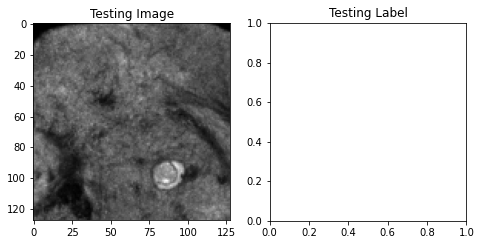

In [14]:
# Step11 呈現隨機cube的某一層結果
#Plot individual slices from test predictions for verification
slice = 45
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()

In [15]:
# Step11_1 評估訓練集的準確度
def f1_score(result, label):
    true_positive = np.sum(np.logical_and(result, label))
    false_positive = np.sum(np.logical_and(result, np.logical_not(label)))
    false_negative = np.sum(np.logical_and(np.logical_not(result), label))

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    f1 = 2 * (precision * recall) / (precision + recall)

    return f1

f1 = f1_score(ground_truth_argmax, test_prediction1)
print("F1 score: ", f1)
# 1. 先計算聯集
A_Label = ground_truth_argmax.copy()
B_Label = test_prediction1.copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = ground_truth_argmax.copy()
B_Label_for_overlap = test_prediction1.copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('IOU_of_3D: ',IOU_of_3D)

NameError: name 'ground_truth_argmax' is not defined

In [16]:
# ======================以上是對訓練集的隨機抽取測試======================
# ======================下方開始對測試集進行腦區預測======================

2023-12-06 11:51:01.945706: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:345] Cancel Transpose nodes around Pad: transpose_before=model_1/bn_data/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=model_1/zero_padding3d/Pad transpose_after=model_1/conv0/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer
2023-12-06 11:51:02.888373: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


原本模型輸出的one hot encode轉換成:  (64, 128, 128)
DLG影像輸入至模型的shape:  (64, 128, 128, 1)
本次隨機抽取的編號:  141


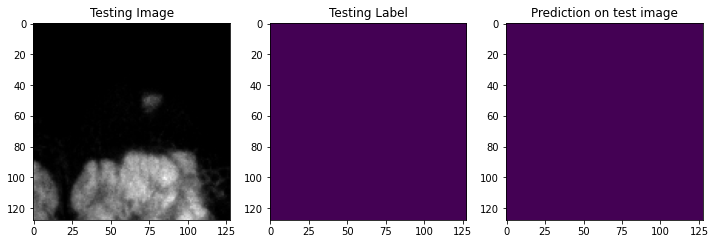

In [6]:
# Step12 使用未參與訓練的大腦測試準確度
# test_img & test_mask 當作測試集
test_img = np.load('2023_3DUNET_Model_INPUT_ONLY_TEST/DLG_INPUT.npy')
test_mask = np.load('2023_3DUNET_Model_INPUT_ONLY_TEST/LABEL_INPUT.npy')

test_img = np.stack((test_img,)*1, axis=-1)# ==========此處可以拓展成3通道或是維持1通道
test_mask = np.expand_dims(test_mask, axis=4)

# 設定總個分類數量
n_classes=2
# 應該是轉換one hot encode
test_mask_cat = to_categorical(test_mask, num_classes=n_classes)
# ====開始隨機預測====
import random
test_img_number = random.randint(0, len(test_img)-1)
test_img = test_img[test_img_number]
ground_truth=test_mask_cat[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
#test_pred1 = model.predict(test_img_input1)

test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print('原本模型輸出的one hot encode轉換成: ',test_prediction1.shape)
ground_truth_argmax = np.argmax(ground_truth, axis=3)
print('DLG影像輸入至模型的shape: ',test_img.shape)
print('本次隨機抽取的編號: ',test_img_number)
slice = 49
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()

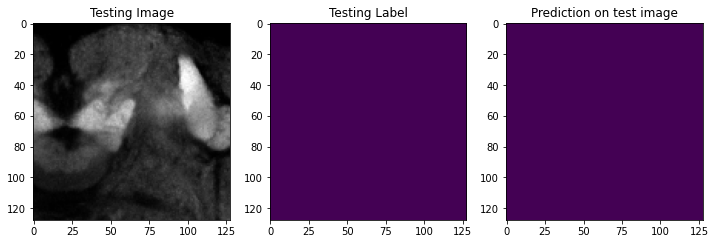

In [7]:
# Step12_1 隨機測試集的cube中不同slice的顯示
slice = 20
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()

In [8]:
# Step13 對隨機測試集的cube評估準確度: 計算F1分數 ( 整體 )
import numpy as np

def f1_score(result, label):
    true_positive = np.sum(np.logical_and(result, label))
    false_positive = np.sum(np.logical_and(result, np.logical_not(label)))
    false_negative = np.sum(np.logical_and(np.logical_not(result), label))
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1
f1 = f1_score(ground_truth_argmax, test_prediction1)
print("F1 score: ", f1)

F1 score:  nan


/tmp/ipykernel_889932/3091831852.py:8: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)


In [9]:
# Step14 對隨機測試集的cube評估準確度: 開始計算IOU
# 1. 先計算聯集
A_Label = ground_truth_argmax.copy()
B_Label = test_prediction1.copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = ground_truth_argmax.copy()
B_Label_for_overlap = test_prediction1.copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('IOU_of_3D: ',IOU_of_3D)

IOU_of_3D:  0.0


In [9]:
# ============目前只對測試集的隨機一個cube進行預測腦區，並評估準確度============
# ============下一步將所有測試集的滑動cube合併(投票)成一個 (124, 168, 168) 3D腦區，滑動cube shape: (64,128,128)============
# 測試集有兩顆腦: Gad1-F-400041_No_1 & Gad1-F-400041_No_2 & VGlut-F-800014_No_1 & VGlut-F-800014_No_2

In [10]:
# Step15 批量對測試集進行讀取、推理腦區、合併
# 讀取測試集
test_img = np.load('2023_3DUNET_Model_INPUT_ONLY_TEST/DLG_INPUT.npy')
test_img = np.stack((test_img,)*1, axis=-1)# ==========此處可以拓展成3通道或是維持1通道
# 將測試集的DLG進行前處理 preprocess_input
test_img_input = preprocess_input(test_img)
# 開始推理
test_pred = my_model.predict(test_img_input,batch_size=1)
# 將推理結果(one hot encode)轉成圖片型式
test_pred = np.argmax(test_pred, axis=4)
# 滑動切割後的shape = (4,3,3,64,128,128)，需要將 test_pred 推理的結果reshape成滑動切割後的shape才能進行下一步還原
# test_pred 包含四個3D腦區的結果 test_pred[:36] = Gad1-F-400041_No_1_DLG
predicted_reshaped_01 = np.reshape(test_pred[:36],(4, 3, 3, 64, 128, 128) )
# test_pred 包含四個3D腦區的結果 test_pred[36:72] = Gad1-F-400041_No_2_DLG
predicted_reshaped_02 = np.reshape(test_pred[36:72],(4, 3, 3, 64, 128, 128) )
# test_pred 包含四個3D腦區的結果 test_pred[72:108] = VGlut-F-800014_No_1_DLG
predicted_reshaped_03 = np.reshape(test_pred[72:108],(4, 3, 3, 64, 128, 128) )
# test_pred 包含四個3D腦區的結果 test_pred[108:144] = VGlut-F-800014_No_2_DLG
predicted_reshaped_04 = np.reshape(test_pred[108:144],(4, 3, 3, 64, 128, 128) )

# =========目前已經準備好unpatchify合併前的 predicted_reshaped_01 & predicted_reshaped_02 & predicted_reshaped_03 & predicted_reshaped_04

2023-12-06 11:51:13.119936: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:345] Cancel Transpose nodes around Pad: transpose_before=model_1/bn_data/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=model_1/zero_padding3d/Pad transpose_after=model_1/conv0/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer


In [11]:
# Step16 定義 _unpatchify3d 函數
from typing import Tuple, Union, cast
Imsize = Union[Tuple[int, int], Tuple[int, int, int]]
def _unpatchify3d(  # pylint: disable=too-many-locals
    patches: np.ndarray, imsize: Tuple[int, int, int]
) -> np.ndarray:
    assert len(patches.shape) == 6
    i_h, i_w, i_c = imsize
    image = np.zeros(imsize, dtype=patches.dtype)
    n_h, n_w, n_c, p_h, p_w, p_c = patches.shape
    s_w = 0 if n_w <= 1 else (i_w - p_w) / (n_w - 1)
    s_h = 0 if n_h <= 1 else (i_h - p_h) / (n_h - 1)
    s_c = 0 if n_c <= 1 else (i_c - p_c) / (n_c - 1)
    # The step size should be same for all patches, otherwise the patches are unable
    # to reconstruct into a image
    if int(s_w) != s_w:
        raise NonUniformStepSizeError(i_w, n_w, p_w, s_w)
    if int(s_h) != s_h:
        raise NonUniformStepSizeError(i_h, n_h, p_h, s_h)
    if int(s_c) != s_c:
        raise NonUniformStepSizeError(i_c, n_c, p_c, s_c)
    s_w = int(s_w)
    s_h = int(s_h)
    s_c = int(s_c)

    i, j, k = 0, 0, 0
    while True:
        i_o, j_o, k_o = i * s_h, j * s_w, k * s_c
        # 原本合併(直接賦予數值)
        #image[i_o : i_o + p_h, j_o : j_o + p_w, k_o : k_o + p_c] = patches[i, j, k]
        # 修改成累加(投票)
        image[i_o : i_o + p_h, j_o : j_o + p_w, k_o : k_o + p_c] = image[i_o : i_o + p_h, j_o : j_o + p_w, k_o : k_o + p_c] + patches[i, j, k]

        if k < n_c - 1:
            k = min((k_o + p_c) // s_c, n_c - 1)
        elif j < n_w - 1 and k >= n_c - 1:
            j = min((j_o + p_w) // s_w, n_w - 1)
            k = 0
        elif i < n_h - 1 and j >= n_w - 1 and k >= n_c - 1:
            i = min((i_o + p_h) // s_h, n_h - 1)
            j = 0
            k = 0
        elif i >= n_h - 1 and j >= n_w - 1 and k >= n_c - 1:
            # Finished
            break
        else:
            raise RuntimeError("Unreachable")
    return image

# Step17 使用 unpatchify 將多個 cubes 合併回 (124,168,168)
reconstructed_No1 = unpatchify(predicted_reshaped_01, (124,168,168))
reconstructed_No2 = unpatchify(predicted_reshaped_02, (124,168,168))
reconstructed_No3 = unpatchify(predicted_reshaped_03, (124,168,168))
reconstructed_No4 = unpatchify(predicted_reshaped_04, (124,168,168))
# 合併後設定閾值，類似投票保留需要發光的範圍
reconstructed_No1[reconstructed_No1<=int(np.max(reconstructed_No1)/3)]=0
reconstructed_No1[reconstructed_No1>int(np.max(reconstructed_No1)/3)]=1
# =
reconstructed_No2[reconstructed_No2<=int(np.max(reconstructed_No2)/3)]=0
reconstructed_No2[reconstructed_No2>int(np.max(reconstructed_No2)/3)]=1
# =
reconstructed_No3[reconstructed_No3<=int(np.max(reconstructed_No3)/3)]=0
reconstructed_No3[reconstructed_No3>int(np.max(reconstructed_No3)/3)]=1
# =
reconstructed_No4[reconstructed_No4<=int(np.max(reconstructed_No4)/3)]=0
reconstructed_No4[reconstructed_No4>int(np.max(reconstructed_No4)/3)]=1
# =====此時 reconstructed_No1~~reconstructed_No4 都是(124,168,168)=====

In [12]:
# Step17 使用 unpatchify 將多個 cubes 合併回 (124,168,168)  ====和AL MB相同
reconstructed_No1 = unpatchify(predicted_reshaped_01, (124,168,168))
reconstructed_No2 = unpatchify(predicted_reshaped_02, (124,168,168))
reconstructed_No3 = unpatchify(predicted_reshaped_03, (124,168,168))
reconstructed_No4 = unpatchify(predicted_reshaped_04, (124,168,168))
# 合併後設定閾值，類似投票保留需要發光的範圍 (不需要投票了)
reconstructed_No1[reconstructed_No1>0]=1
reconstructed_No2[reconstructed_No2>0]=1
reconstructed_No3[reconstructed_No3>0]=1
reconstructed_No4[reconstructed_No4>0]=1
# 合併後設定閾值，類似投票保留需要發光的範圍
# reconstructed_No1[reconstructed_No1<=int(np.max(reconstructed_No1)/3)]=0
# reconstructed_No1[reconstructed_No1>int(np.max(reconstructed_No1)/3)]=1
# # =
# reconstructed_No2[reconstructed_No2<=int(np.max(reconstructed_No2)/3)]=0
# reconstructed_No2[reconstructed_No2>int(np.max(reconstructed_No2)/3)]=1
# # =
# reconstructed_No3[reconstructed_No3<=int(np.max(reconstructed_No3)/3)]=0
# reconstructed_No3[reconstructed_No3>int(np.max(reconstructed_No3)/3)]=1
# # =
# reconstructed_No4[reconstructed_No4<=int(np.max(reconstructed_No4)/3)]=0
# reconstructed_No4[reconstructed_No4>int(np.max(reconstructed_No4)/3)]=1
# # =====此時 reconstructed_No1~~reconstructed_No4 都是(124,168,168)=====

In [13]:
# Step17_1 新增去除3D誤判的物體(雜訊?) ====對預測結果處理====
from skimage import measure
# reconstructed_No1
labels = measure.label(reconstructed_No1, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
regions = measure.regionprops(labels)
# 計算封閉區域的數量
num_regions = len(regions)
print('Gad1-F-400041_No_1')
# 計算每個區域的像素數量
for region in regions:
    print("Region area: ", region.area)
print("Number of closed areas: ", num_regions)
# 找到最大的Region area
max_area_index = np.argmax([region.area for region in regions])
# 設置除了最大的Region area之外的所有區域為0
for i, region in enumerate(regions):
    if i != max_area_index:
        reconstructed_No1[tuple(region.coords.T)] = 0
# 將大於0的位置設為1
reconstructed_No1[reconstructed_No1>0] =1
# # 輸出tif存檔
# tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/Fix_CRICK_F_04_D0427_01_No_1_result.tif',labels.astype('uint8'))
# print('=========')
# reconstructed_No2
labels = measure.label(reconstructed_No2, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
regions = measure.regionprops(labels)
# 計算封閉區域的數量
num_regions = len(regions)
print('Gad1-F-400041_No_2')
# 計算每個區域的像素數量
for region in regions:
    print("Region area: ", region.area)
print("Number of closed areas: ", num_regions)
# 找到最大的Region area
max_area_index = np.argmax([region.area for region in regions])
# 設置除了最大的Region area之外的所有區域為0
for i, region in enumerate(regions):
    if i != max_area_index:
        reconstructed_No2[tuple(region.coords.T)] = 0
# 將大於0的位置設為1
reconstructed_No2[reconstructed_No2>0] =1
# # 輸出tif存檔
# tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/Fix_CRICK_F_04_D0427_01_No_1_result.tif',labels.astype('uint8'))
# print('=========')
# reconstructed_No3
labels = measure.label(reconstructed_No3, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
regions = measure.regionprops(labels)
# 計算封閉區域的數量
num_regions = len(regions)
print('VGlut-F-800014_No_1')
# 計算每個區域的像素數量
for region in regions:
    print("Region area: ", region.area)
print("Number of closed areas: ", num_regions)
# 找到最大的Region area
max_area_index = np.argmax([region.area for region in regions])
# 設置除了最大的Region area之外的所有區域為0
for i, region in enumerate(regions):
    if i != max_area_index:
        reconstructed_No3[tuple(region.coords.T)] = 0
# 將大於0的位置設為1
reconstructed_No3[reconstructed_No3>0] =1
# # 輸出tif存檔
# tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/Fix_CRICK_F_04_D0427_01_No_1_result.tif',labels.astype('uint8'))
# print('=========')
# reconstructed_No4
labels = measure.label(reconstructed_No4, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
regions = measure.regionprops(labels)
# 計算封閉區域的數量
num_regions = len(regions)
print('VGlut-F-800014_No_2')
# 計算每個區域的像素數量
for region in regions:
    print("Region area: ", region.area)
print("Number of closed areas: ", num_regions)
# 找到最大的Region area
max_area_index = np.argmax([region.area for region in regions])
# 設置除了最大的Region area之外的所有區域為0
for i, region in enumerate(regions):
    if i != max_area_index:
        reconstructed_No4[tuple(region.coords.T)] = 0
# 將大於0的位置設為1
reconstructed_No4[reconstructed_No4>0] =1
# # 輸出tif存檔
# tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/Fix_CRICK_F_04_D0427_01_No_1_result.tif',labels.astype('uint8'))
# print('=========')

Gad1-F-400041_No_1
Region area:  36995
Number of closed areas:  1
Gad1-F-400041_No_2
Region area:  36467
Number of closed areas:  1
VGlut-F-800014_No_1
Region area:  43608
Number of closed areas:  1
VGlut-F-800014_No_2
Region area:  43078
Region area:  35
Region area:  1
Region area:  1
Number of closed areas:  4


In [14]:
# Step18 評估合併還原後的 reconstructed_No1~~reconstructed_No4 和正確答案的準確度(F1 score)
# 先讀取正確答案並重新reshape，再進行合併
test_mask = np.load('2023_3DUNET_Model_INPUT_ONLY_TEST/LABEL_INPUT.npy')
# 滑動切割後的shape = (4,3,3,64,128,128)，需要將 test_mask(正確腦區答案) reshape成滑動切割後的shape才能進行下一步還原
# test_mask 包含四個3D腦區的結果 test_mask[:36] = Gad1-F-400041_No_1_LABEL
Label_reshaped_01 = np.reshape(test_mask[:36],(4, 3, 3, 64, 128, 128) )
# test_mask 包含四個3D腦區的結果 test_mask[36:72] = Gad1-F-400041_No_2_LABEL
Label_reshaped_02 = np.reshape(test_mask[36:72],(4, 3, 3, 64, 128, 128) )
# test_mask 包含四個3D腦區的結果 test_mask[72:108] = VGlut-F-800014_No_1_LABEL
Label_reshaped_03 = np.reshape(test_mask[72:108],(4, 3, 3, 64, 128, 128) )
# test_mask 包含四個3D腦區的結果 test_mask[108:144] = VGlut-F-800014_No_2_LABEL
Label_reshaped_04 = np.reshape(test_mask[108:144],(4, 3, 3, 64, 128, 128) )
# =====上方完成reshape，下一步要進行合併=====
# 使用 unpatchify 將多個 cubes 合併回 (124,168,168)
Label_reconstructed_No1 = unpatchify(Label_reshaped_01, (124,168,168))
Label_reconstructed_No2 = unpatchify(Label_reshaped_02, (124,168,168))
Label_reconstructed_No3 = unpatchify(Label_reshaped_03, (124,168,168))
Label_reconstructed_No4 = unpatchify(Label_reshaped_04, (124,168,168))
# 合併後設定閾值，類似投票保留需要發光的範圍
Label_reconstructed_No1[Label_reconstructed_No1<=int(np.max(Label_reconstructed_No1)/3)]=0
Label_reconstructed_No1[Label_reconstructed_No1>int(np.max(Label_reconstructed_No1)/3)]=1
# =
Label_reconstructed_No2[Label_reconstructed_No2<=int(np.max(Label_reconstructed_No2)/3)]=0
Label_reconstructed_No2[Label_reconstructed_No2>int(np.max(Label_reconstructed_No2)/3)]=1
# =
Label_reconstructed_No3[Label_reconstructed_No3<=int(np.max(Label_reconstructed_No3)/3)]=0
Label_reconstructed_No3[Label_reconstructed_No3>int(np.max(Label_reconstructed_No3)/3)]=1
# =
Label_reconstructed_No4[Label_reconstructed_No4<=int(np.max(Label_reconstructed_No4)/3)]=0
Label_reconstructed_No4[Label_reconstructed_No4>int(np.max(Label_reconstructed_No4)/3)]=1
# ========================也需要對GT進行排除3D多餘物體(因為YOLO切割範圍會包含另一側的小部分腦區)========================
# Label_reconstructed_No1
labels = measure.label(Label_reconstructed_No1, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
regions = measure.regionprops(labels)
# 計算封閉區域的數量
num_regions = len(regions)
print('Gad1-F-400041_No_1_LABEL')
# 計算每個區域的像素數量
for region in regions:
    print("Region area: ", region.area)
print("Number of closed areas: ", num_regions)
# 找到最大的Region area
max_area_index = np.argmax([region.area for region in regions])
# 設置除了最大的Region area之外的所有區域為0
for i, region in enumerate(regions):
    if i != max_area_index:
        Label_reconstructed_No1[tuple(region.coords.T)] = 0
# 將大於0的位置設為1
Label_reconstructed_No1[Label_reconstructed_No1>0] =1
# # 輸出tif存檔
# tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/Fix_CRICK_F_04_D0427_01_No_1_result.tif',labels.astype('uint8'))
# print('=========')
# Label_reconstructed_No2
labels = measure.label(Label_reconstructed_No2, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
regions = measure.regionprops(labels)
# 計算封閉區域的數量
num_regions = len(regions)
print('Gad1-F-400041_No_2_LABEL')
# 計算每個區域的像素數量
for region in regions:
    print("Region area: ", region.area)
print("Number of closed areas: ", num_regions)
# 找到最大的Region area
max_area_index = np.argmax([region.area for region in regions])
# 設置除了最大的Region area之外的所有區域為0
for i, region in enumerate(regions):
    if i != max_area_index:
        Label_reconstructed_No2[tuple(region.coords.T)] = 0
# 將大於0的位置設為1
Label_reconstructed_No2[Label_reconstructed_No2>0] =1
# # 輸出tif存檔
# tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/Fix_CRICK_F_04_D0427_01_No_1_result.tif',labels.astype('uint8'))
# print('=========')
# Label_reconstructed_No3
labels = measure.label(Label_reconstructed_No3, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
regions = measure.regionprops(labels)
# 計算封閉區域的數量
num_regions = len(regions)
print('VGlut-F-800014_No_1_LABEL')
# 計算每個區域的像素數量
for region in regions:
    print("Region area: ", region.area)
print("Number of closed areas: ", num_regions)
# 找到最大的Region area
max_area_index = np.argmax([region.area for region in regions])
# 設置除了最大的Region area之外的所有區域為0
for i, region in enumerate(regions):
    if i != max_area_index:
        Label_reconstructed_No3[tuple(region.coords.T)] = 0
# 將大於0的位置設為1
Label_reconstructed_No3[Label_reconstructed_No3>0] =1
# # 輸出tif存檔
# tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/Fix_CRICK_F_04_D0427_01_No_1_result.tif',labels.astype('uint8'))
# print('=========')
# Label_reconstructed_No4
labels = measure.label(Label_reconstructed_No4, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
regions = measure.regionprops(labels)
# 計算封閉區域的數量
num_regions = len(regions)
print('VGlut-F-800014_No_2_LABEL')
# 計算每個區域的像素數量
for region in regions:
    print("Region area: ", region.area)
print("Number of closed areas: ", num_regions)
# 找到最大的Region area
max_area_index = np.argmax([region.area for region in regions])
# 設置除了最大的Region area之外的所有區域為0
for i, region in enumerate(regions):
    if i != max_area_index:
        Label_reconstructed_No4[tuple(region.coords.T)] = 0
# 將大於0的位置設為1
Label_reconstructed_No4[Label_reconstructed_No4>0] =1
# # 輸出tif存檔
# tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/Fix_CRICK_F_04_D0427_01_No_1_result.tif',labels.astype('uint8'))
# print('=========')
# =======開始計算F1分數=======
def f1_score(result, label):
    true_positive = np.sum(np.logical_and(result, label))
    false_positive = np.sum(np.logical_and(result, np.logical_not(label)))
    false_negative = np.sum(np.logical_and(np.logical_not(result), label))
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1,precision,recall
f1,precision,recall = f1_score(Label_reconstructed_No1, reconstructed_No1)
print("Gad1-F-400041_No_1_F1 score: ", f1)
print("Gad1-F-400041_No_1_precision score: ", precision)
print("Gad1-F-400041_No_1_recall score: ", recall)
f1,precision,recall = f1_score(Label_reconstructed_No2, reconstructed_No2)
print("Gad1-F-400041_No_2_F1 score: ", f1)
print("Gad1-F-400041_No_2_precision score: ", precision)
print("Gad1-F-400041_No_2_recall score: ", recall)
f1,precision,recall = f1_score(Label_reconstructed_No3, reconstructed_No3)
print("VGlut-F-800014_No_1_F1 score: ", f1)
print("VGlut-F-800014_No_1_precision score: ", precision)
print("VGlut-F-800014_No_1_recall score: ", recall)
f1,precision,recall = f1_score(Label_reconstructed_No4, reconstructed_No4)
print("VGlut-F-800014_No_2_F1 score: ", f1)
print("VGlut-F-800014_No_2_precision score: ", precision)
print("VGlut-F-800014_No_2_recall score: ", recall)
# Gad1-F-400041_No_1_F1 score:  0.9025690637428786
# Gad1-F-400041_No_2_F1 score:  0.8749424154444457
# VGlut-F-800014_No_1_F1 score:  0.4275132829062738
# VGlut-F-800014_No_2_F1 score:  0.835955765020225
# 最新訓練16
# Gad1-F-400041_No_1_F1 score:  0.9496489854236216
# Gad1-F-400041_No_2_F1 score:  0.9421649903912244
# VGlut-F-800014_No_1_F1 score:  0.9436724902688512
# VGlut-F-800014_No_2_F1 score:  0.9408372490388722

Gad1-F-400041_No_1_LABEL
Region area:  35794
Number of closed areas:  1
Gad1-F-400041_No_2_LABEL
Region area:  34822
Number of closed areas:  1
VGlut-F-800014_No_1_LABEL
Region area:  44768
Number of closed areas:  1
VGlut-F-800014_No_2_LABEL
Region area:  41198
Number of closed areas:  1
Gad1-F-400041_No_1_F1 score:  0.9496489854236216
Gad1-F-400041_No_1_precision score:  0.9655808236017209
Gad1-F-400041_No_1_recall score:  0.9342343559940532
Gad1-F-400041_No_2_F1 score:  0.9421649903912244
Gad1-F-400041_No_2_precision score:  0.9644190454310493
Gad1-F-400041_No_2_recall score:  0.9209147996819042
VGlut-F-800014_No_1_F1 score:  0.9436724902688512
VGlut-F-800014_No_1_precision score:  0.9314465689778413
VGlut-F-800014_No_1_recall score:  0.9562236286919831
VGlut-F-800014_No_2_F1 score:  0.9408372490388722
VGlut-F-800014_No_2_precision score:  0.9623039953395796
VGlut-F-800014_No_2_recall score:  0.9203073494591206


In [15]:
# Step19_0 將測試腦的全部腦區量化分數取平均
# 儲存每個實驗的 F1、precision、recall
f1_scores = []
precision_scores = []
recall_scores = []

# 第一個實驗的結果
f1, precision, recall = f1_score(Label_reconstructed_No1, reconstructed_No1)
f1_scores.append(f1)
precision_scores.append(precision)
recall_scores.append(recall)

# 第二個實驗的結果
f1, precision, recall = f1_score(Label_reconstructed_No2, reconstructed_No2)
f1_scores.append(f1)
precision_scores.append(precision)
recall_scores.append(recall)

# 第三個實驗的結果
f1, precision, recall = f1_score(Label_reconstructed_No3, reconstructed_No3)
f1_scores.append(f1)
precision_scores.append(precision)
recall_scores.append(recall)

# 第四個實驗的結果
f1, precision, recall = f1_score(Label_reconstructed_No4, reconstructed_No4)
f1_scores.append(f1)
precision_scores.append(precision)
recall_scores.append(recall)

# 計算平均分數
avg_f1 = sum(f1_scores) / len(f1_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)

print("Average F1 score: ", avg_f1)
print("Average Precision score: ", avg_precision)
print("Average Recall score: ", avg_recall)


Average F1 score:  0.9440809287806424
Average Precision score:  0.9559376083375478
Average Recall score:  0.9329200334567652


In [2]:
# 平均3D-IoU
print('3D-IoU: ',(0.9041253564234704 + 0.8906540073197899 + 0.8933521863016046 + 0.888283928211333)/4)

3D-IoU:  0.8941038695640495


In [16]:
# Step19_1 對測試集的cube評估準確度: 開始計算IOU
# 1. 先計算聯集
A_Label = Label_reconstructed_No1.copy()
B_Label = reconstructed_No1.copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = Label_reconstructed_No1.copy()
B_Label_for_overlap = reconstructed_No1.copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('Gad1-F-400041_No_1_IOU_of_3D: ',IOU_of_3D)
# Gad1-F-400041_No_1_IOU_of_3D:  0.8224381452387016
# 16訓練結果: 0.9041253564234704

Gad1-F-400041_No_1_IOU_of_3D:  0.9041253564234704


In [17]:
# Step19_2 對測試集的cube評估準確度: 開始計算IOU
# 1. 先計算聯集
A_Label = Label_reconstructed_No2.copy()
B_Label = reconstructed_No2.copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = Label_reconstructed_No2.copy()
B_Label_for_overlap = reconstructed_No2.copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('Gad1-F-400041_No_2_IOU_of_3D: ',IOU_of_3D)
# Gad1-F-400041_No_2_IOU_of_3D:  0.7776867846191936
# 16訓練結果: 0.8906540073197899

Gad1-F-400041_No_2_IOU_of_3D:  0.8906540073197899


In [18]:
# Step19_3 對測試集的cube評估準確度: 開始計算IOU
# 1. 先計算聯集
A_Label = Label_reconstructed_No3.copy()
B_Label = reconstructed_No3.copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = Label_reconstructed_No3.copy()
B_Label_for_overlap = reconstructed_No3.copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('VGlut-F-800014_No_1_IOU_of_3D: ',IOU_of_3D)
# VGlut-F-800014_No_1_IOU_of_3D: 0.27187083888149133
# 16訓練結果: 0.8933521863016046

VGlut-F-800014_No_1_IOU_of_3D:  0.8933521863016046


In [19]:
# Step19_4 對測試集的cube評估準確度: 開始計算IOU
# 1. 先計算聯集
A_Label = Label_reconstructed_No4.copy()
B_Label = reconstructed_No4.copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = Label_reconstructed_No4.copy()
B_Label_for_overlap = reconstructed_No4.copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('VGlut-F-800014_No_2_IOU_of_3D: ',IOU_of_3D)
# VGlut-F-800014_No_2_IOU_of_3D:  0.718147764405834
# 16訓練結果: 0.888283928211333

VGlut-F-800014_No_2_IOU_of_3D:  0.888283928211333


In [20]:
# =======================新增測試: 放大回原始解析度，在進行3D-IoU比較=======================
Gad1_No_1_DLG = np.load('2023_18_Brain_3DUNET_DataSet/'+'Gad1-F-400041'+'_No_1_original_DLG.npy')
Gad1_No_2_DLG = np.load('2023_18_Brain_3DUNET_DataSet/'+'Gad1-F-400041'+'_No_2_original_DLG.npy')
Gad1_No_1_LABEL = np.load('2023_18_Brain_3DUNET_DataSet/'+'Gad1-F-400041'+'_No_1_original_LABEL.npy')
Gad1_No_2_LABEL = np.load('2023_18_Brain_3DUNET_DataSet/'+'Gad1-F-400041'+'_No_2_original_LABEL.npy')
#====
VGlut_No_1_DLG = np.load('2023_18_Brain_3DUNET_DataSet/'+'VGlut-F-800014'+'_No_1_original_DLG.npy')
VGlut_No_2_DLG = np.load('2023_18_Brain_3DUNET_DataSet/'+'VGlut-F-800014'+'_No_2_original_DLG.npy')
VGlut_No_1_LABEL = np.load('2023_18_Brain_3DUNET_DataSet/'+'VGlut-F-800014'+'_No_1_original_LABEL.npy')
VGlut_No_2_LABEL = np.load('2023_18_Brain_3DUNET_DataSet/'+'VGlut-F-800014'+'_No_2_original_LABEL.npy')

All_Test_DLG = []
All_Test_DLG.append(Gad1_No_1_DLG)
All_Test_DLG.append(Gad1_No_2_DLG)
All_Test_DLG.append(VGlut_No_1_DLG)
All_Test_DLG.append(VGlut_No_2_DLG)

All_Test_LABEL = []
All_Test_LABEL.append(Gad1_No_1_LABEL)
All_Test_LABEL.append(Gad1_No_2_LABEL)
All_Test_LABEL.append(VGlut_No_1_LABEL)
All_Test_LABEL.append(VGlut_No_2_LABEL)

In [21]:
# Step20_0新增測試: 先將測試集的Label拓展Z軸至124
# 這是要對Z軸添加的空白層
import cv2
def pad_to_compatible_shape(array):
    """
    為3D陣列添加所需的填充層
    """
    z_length = array.shape[0]
    y_x_length = array.shape[1]
    while (z_length - 64) % 20 != 0:
        padding_layer = np.zeros((1, y_x_length, y_x_length))
        array = np.vstack((array, padding_layer))
        z_length += 1
    
    return array
# 將每一個3D array進行填充 變成 124,1024,1024
Test_DLG_padded = [pad_to_compatible_shape(arr) for arr in All_Test_DLG]# ==================此處要換變數
Test_Label_padded = [pad_to_compatible_shape(arr) for arr in All_Test_LABEL]# ==================此處要換變數
# =============================== Test_DLG_padded & Test_Label_padded 包含了兩個測試大腦拓展後Z軸的DLG 和 Label
# 將預測結果放大成 124,1024,1024
# ========================先處理 reconstructed_No1 放大後加入 Test_Label_resized========================
Test_Label_resized = []
z, x, y = Test_Label_padded[0].shape#===========================這裡要修改
resized_arr = np.zeros((z, x, x))
reconstructed_No1 = reconstructed_No1.astype(np.float32)
for i in range(z):
    resized_arr[i] = cv2.resize(reconstructed_No1[i], (x, x), interpolation=cv2.INTER_AREA)

Test_Label_resized.append(resized_arr)
# ============
# ========================處理 reconstructed_No2 放大後加入 Test_Label_resized========================
z, x, y = Test_Label_padded[1].shape#===========================這裡要修改
resized_arr = np.zeros((z, x, x))
reconstructed_No2 = reconstructed_No2.astype(np.float32)
for i in range(z):
    resized_arr[i] = cv2.resize(reconstructed_No2[i], (x, x), interpolation=cv2.INTER_AREA)

Test_Label_resized.append(resized_arr)
# ============
# ========================處理 reconstructed_No3 放大後加入 Test_Label_resized========================
z, x, y = Test_Label_padded[2].shape#===========================這裡要修改
resized_arr = np.zeros((z, x, x))
reconstructed_No3 = reconstructed_No3.astype(np.float32)
for i in range(z):
    resized_arr[i] = cv2.resize(reconstructed_No3[i], (x, x), interpolation=cv2.INTER_AREA)

Test_Label_resized.append(resized_arr)
# ============
# ========================處理 reconstructed_No4 放大後加入 Test_Label_resized========================
z, x, y = Test_Label_padded[3].shape#===========================這裡要修改
resized_arr = np.zeros((z, x, x))
reconstructed_No4 = reconstructed_No4.astype(np.float32)
for i in range(z):
    resized_arr[i] = cv2.resize(reconstructed_No4[i], (x, x), interpolation=cv2.INTER_AREA)

Test_Label_resized.append(resized_arr)
# =============================== Test_Label_resized 是包含了兩個測試腦預測結果，放大回 124,1024,1024的結果
# 標準化 Test_Label_padded & Test_Label_resized
# Test_Label_padded = np.array(Test_Label_padded)
# Test_prediction = np.array(Test_Label_resized)
# Test_Label_padded[Test_Label_padded > 0] = 1
# Test_prediction[Test_prediction > 0] = 1
Test_prediction = Test_Label_resized.copy()
# 輸出 Test_DLG_padded  & Test_Label_padded & Test_prediction

In [22]:
# 分析放大回原解析度的3D IoU
# 1. 先計算聯集
A_Label = Test_Label_padded[0].copy()
B_Label = Test_prediction[0].copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = Test_Label_padded[0].copy()
B_Label_for_overlap = Test_prediction[0].copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('Gad1-F-400041_No_1_IOU_of_3D: ',IOU_of_3D)


Gad1-F-400041_No_1_IOU_of_3D:  0.875314333612741


In [23]:
# 分析放大回原解析度的3D IoU
# 1. 先計算聯集
A_Label = Test_Label_padded[1].copy()
B_Label = Test_prediction[1].copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = Test_Label_padded[1].copy()
B_Label_for_overlap = Test_prediction[1].copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('Gad1-F-400041_No_2_IOU_of_3D: ',IOU_of_3D)


Gad1-F-400041_No_2_IOU_of_3D:  0.8629041322536991


In [24]:
# 分析放大回原解析度的3D IoU
# 1. 先計算聯集
A_Label = Test_Label_padded[2].copy()
B_Label = Test_prediction[2].copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = Test_Label_padded[2].copy()
B_Label_for_overlap = Test_prediction[2].copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('VGlut-F-800014_No_1_IOU_of_3D: ',IOU_of_3D)


VGlut-F-800014_No_1_IOU_of_3D:  0.8708094557834299


In [25]:
# 分析放大回原解析度的3D IoU
# 1. 先計算聯集
A_Label = Test_Label_padded[3].copy()
B_Label = Test_prediction[3].copy()
Union_3D_region = A_Label+B_Label
# 將兩個來源的發光位置相加，重疊處也設為1(這是聯集)
Union_3D_region[Union_3D_region>0]=1
# 2. 計算交集
A_Label_for_overlap = Test_Label_padded[3].copy()
B_Label_for_overlap = Test_prediction[3].copy()
Intersection_3D_region = A_Label_for_overlap+B_Label_for_overlap
# 有交集的地方會是2 將非2的地方歸零，再將2變成1方便計算數量
Intersection_3D_region[Intersection_3D_region<2]=0
Intersection_3D_region[Intersection_3D_region>0]=1
# 完成 交集 和 聯集 ，開始計算IOU
IOU_of_3D = np.sum(Intersection_3D_region)/np.sum(Union_3D_region)
print('VGlut-F-800014_No_2_IOU_of_3D: ',IOU_of_3D)


VGlut-F-800014_No_2_IOU_of_3D:  0.8678958372932902


In [26]:
# 平均3D-IoU
print('3D-IoU: ',(0.875314333612741 + 0.8629041322536991 + 0.8708094557834299 + 0.8678958372932902)/4)
# 縮放回原始解析度之前: 3D-IoU:  0.8941038695640495


# 縮放回原始解析度之後: 3D-IoU:  0.86923093973579

3D-IoU:  0.86923093973579


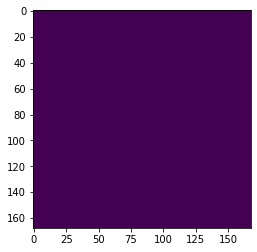

In [38]:
plt.imshow(Label_reconstructed_No1[40,:,:])
# 人工比對後，確認 Label合併後是正確的

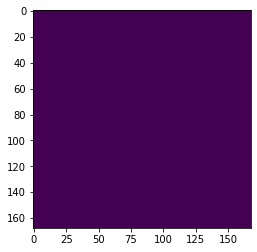

In [39]:
plt.imshow(reconstructed_No1[40,:,:])
# 人工比對後，確認 Label合併後是正確的

In [40]:
# Step20 將測試集的預測結果繪製邊界，和DLG影像進行疊圖分析
import cv2
# 繪製邊界: reconstructed_No1
reconstructed_No1_list = []
for i in range(len(reconstructed_No1)):
    img = (reconstructed_No1[i]/np.max(reconstructed_No1[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    reconstructed_No1_list.append(Final_img)# 先將邊界新增至 AL_L_Neuropil_boundary
reconstructed_No1_list = np.array(reconstructed_No1_list)
# = 
# 繪製邊界: reconstructed_No2
reconstructed_No2_list = []
for i in range(len(reconstructed_No2)):
    img = (reconstructed_No2[i]/np.max(reconstructed_No2[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    reconstructed_No2_list.append(Final_img)# 先將邊界新增至 AL_L_Neuropil_boundary
reconstructed_No2_list = np.array(reconstructed_No2_list)
# = 
# 繪製邊界: reconstructed_No3
reconstructed_No3_list = []
for i in range(len(reconstructed_No3)):
    img = (reconstructed_No3[i]/np.max(reconstructed_No3[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    reconstructed_No3_list.append(Final_img)# 先將邊界新增至 AL_L_Neuropil_boundary
reconstructed_No3_list = np.array(reconstructed_No3_list)
# = 
# 繪製邊界: reconstructed_No4
reconstructed_No4_list = []
for i in range(len(reconstructed_No4)):
    img = (reconstructed_No4[i]/np.max(reconstructed_No4[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    reconstructed_No4_list.append(Final_img)# 先將邊界新增至 AL_L_Neuropil_boundary
reconstructed_No4_list = np.array(reconstructed_No4_list)

/tmp/ipykernel_1518861/302487226.py:6: RuntimeWarning: invalid value encountered in divide
  img = (reconstructed_No1[i]/np.max(reconstructed_No1[i])*255).astype(np.uint8)
/tmp/ipykernel_1518861/302487226.py:27: RuntimeWarning: invalid value encountered in divide
  img = (reconstructed_No2[i]/np.max(reconstructed_No2[i])*255).astype(np.uint8)
/tmp/ipykernel_1518861/302487226.py:48: RuntimeWarning: invalid value encountered in divide
  img = (reconstructed_No3[i]/np.max(reconstructed_No3[i])*255).astype(np.uint8)
/tmp/ipykernel_1518861/302487226.py:69: RuntimeWarning: invalid value encountered in divide
  img = (reconstructed_No4[i]/np.max(reconstructed_No4[i])*255).astype(np.uint8)


In [41]:
!rm -r 2023_3D_UNET_Gad1-F-400041_No_1_預測結果
!rm -r 2023_3D_UNET_Gad1-F-400041_No_2_預測結果
!rm -r 2023_3D_UNET_VGlut-F-800014_No_1_預測結果
!rm -r 2023_3D_UNET_VGlut-F-800014_No_2_預測結果

!mkdir 2023_3D_UNET_Gad1-F-400041_No_1_預測結果
!mkdir 2023_3D_UNET_Gad1-F-400041_No_2_預測結果
!mkdir 2023_3D_UNET_VGlut-F-800014_No_1_預測結果
!mkdir 2023_3D_UNET_VGlut-F-800014_No_2_預測結果

In [42]:
# 準備論文Fig1，請跳躍至 Step23
# 準備論文Fig2，請跳躍至 Step24、Step25新增預測結果MASK版本(因為原本預測結果是用輪廓疊加在DLG上)
# 準備論文Fig3，請跳躍製 Step26，新增DLG 疊加 預測結果邊界 疊加 GT邊界

In [43]:
# Step21 讀取測試集DLG圖片，並準備和邊界疊合
test_DLG = np.load('2023_3DUNET_Model_INPUT_ONLY_TEST/DLG_INPUT.npy')
# 滑動切割後的shape = (4,3,3,64,128,128)，需要將 test_mask(正確腦區答案) reshape成滑動切割後的shape才能進行下一步還原
# test_DLG 包含四個3D腦區的結果 test_DLG[:36] = Gad1-F-400041_No_1_LABEL
DLG_reshaped_01 = np.reshape(test_DLG[:36],(4, 3, 3, 64, 128, 128) )
# test_DLG 包含四個3D腦區的結果 test_DLG[36:72] = Gad1-F-400041_No_2_LABEL
DLG_reshaped_02 = np.reshape(test_DLG[36:72],(4, 3, 3, 64, 128, 128) )
# test_DLG 包含四個3D腦區的結果 test_DLG[72:108] = VGlut-F-800014_No_1_LABEL
DLG_reshaped_03 = np.reshape(test_DLG[72:108],(4, 3, 3, 64, 128, 128) )
# test_DLG 包含四個3D腦區的結果 test_DLG[108:144] = VGlut-F-800014_No_2_LABEL
DLG_reshaped_04 = np.reshape(test_DLG[108:144],(4, 3, 3, 64, 128, 128) )
# =====上方完成reshape，下一步要進行合併=====
# 使用 unpatchify 將多個 cubes 合併回 (124,168,168)
DLG_reconstructed_No1 = unpatchify(DLG_reshaped_01, (124,168,168))
DLG_reconstructed_No2 = unpatchify(DLG_reshaped_02, (124,168,168))
DLG_reconstructed_No3 = unpatchify(DLG_reshaped_03, (124,168,168))
DLG_reconstructed_No4 = unpatchify(DLG_reshaped_04, (124,168,168))
# =============上方完成將DLG變成 (124,168,168)=============
# 設定預測結果使用的顏色，目前是設定成預測的專屬顏色(對應PPT內的顏色)
mask_color = '#00B0F0'#預測結果的顏色

# = DLG_reconstructed_No1 & reconstructed_No1_list
for Z in range(len(DLG_reconstructed_No1)):
    fig, ax = plt.subplots(figsize=(25,25))
    ax.imshow(DLG_reconstructed_No1[Z],cmap='gray')
    plt.axis('off')
    x = np.where(reconstructed_No1_list[Z]>0)[0]
    y = np.where(reconstructed_No1_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=mask_color)
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_1_預測結果/'+str(Z) +'.jpg')
    #plt.show()
    plt.close()  # 關閉圖片
# = DLG_reconstructed_No2 & reconstructed_No2_list
for Z in range(len(DLG_reconstructed_No2)):
    fig, ax = plt.subplots(figsize=(25,25))
    ax.imshow(DLG_reconstructed_No2[Z],cmap='gray')
    plt.axis('off')
    x = np.where(reconstructed_No2_list[Z]>0)[0]
    y = np.where(reconstructed_No2_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=mask_color)
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_2_預測結果/'+str(Z) +'.jpg')
    #plt.show()
    plt.close()  # 關閉圖片
# = DLG_reconstructed_No3 & reconstructed_No3_list
for Z in range(len(DLG_reconstructed_No3)):
    fig, ax = plt.subplots(figsize=(25,25))
    ax.imshow(DLG_reconstructed_No3[Z],cmap='gray')
    plt.axis('off')
    x = np.where(reconstructed_No3_list[Z]>0)[0]
    y = np.where(reconstructed_No3_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=mask_color)
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_1_預測結果/'+str(Z) +'.jpg')
    #plt.show()
    plt.close()  # 關閉圖片
# = DLG_reconstructed_No4 & reconstructed_No4_list
for Z in range(len(DLG_reconstructed_No4)):
    fig, ax = plt.subplots(figsize=(25,25))
    ax.imshow(DLG_reconstructed_No4[Z],cmap='gray')
    plt.axis('off')
    x = np.where(reconstructed_No4_list[Z]>0)[0]
    y = np.where(reconstructed_No4_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=mask_color)
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_2_預測結果/'+str(Z) +'.jpg')
    #plt.show()
    plt.close()  # 關閉圖片

In [44]:
# Step22 製作動畫(GIF)
import imageio
images = []
filenames = np.arange(len(DLG_reconstructed_No1))
for filename in filenames:
    images.append(imageio.imread('2023_3D_UNET_Gad1-F-400041_No_1_預測結果/'+str(filename)+'.jpg'))
imageio.mimsave('動畫GIF_3D_UNET_'+seg_target+'_Gad1-F-400041_No_1_預測結果.gif', images)

images = []
filenames = np.arange(len(DLG_reconstructed_No2))
for filename in filenames:
    images.append(imageio.imread('2023_3D_UNET_Gad1-F-400041_No_2_預測結果/'+str(filename)+'.jpg'))
imageio.mimsave('動畫GIF_3D_UNET_'+seg_target+'_Gad1-F-400041_No_2_預測結果.gif', images)

images = []
filenames = np.arange(len(DLG_reconstructed_No3))
for filename in filenames:
    images.append(imageio.imread('2023_3D_UNET_VGlut-F-800014_No_1_預測結果/'+str(filename)+'.jpg'))
imageio.mimsave('動畫GIF_3D_UNET_'+seg_target+'_VGlut-F-800014_No_1_預測結果.gif', images)

images = []
filenames = np.arange(len(DLG_reconstructed_No4))
for filename in filenames:
    images.append(imageio.imread('2023_3D_UNET_VGlut-F-800014_No_2_預測結果/'+str(filename)+'.jpg'))
imageio.mimsave('動畫GIF_3D_UNET_'+seg_target+'_VGlut-F-800014_No_2_預測結果.gif', images)

In [45]:
# Step23 輸出測試集的tif腦區檔案
import tifffile as tif
# 輸出至: 2023_2個測試集_預測結果_tif檔案 資料夾
# 輸出存檔
# 輸出存檔
!rm -r 2023_2個測試集_預測結果_tif檔案
!mkdir 2023_2個測試集_預測結果_tif檔案
tif.imsave('2023_2個測試集_預測結果_tif檔案/Gad1-F-400041_No_1_result.tif',reconstructed_No1.astype('uint8'))
tif.imsave('2023_2個測試集_預測結果_tif檔案/Gad1-F-400041_No_2_result.tif',reconstructed_No2.astype('uint8'))
tif.imsave('2023_2個測試集_預測結果_tif檔案/VGlut-F-800014_No_1_result.tif',reconstructed_No3.astype('uint8'))
tif.imsave('2023_2個測試集_預測結果_tif檔案/VGlut-F-800014_No_2_result.tif',reconstructed_No4.astype('uint8'))

In [ ]:
# Step24 輸出預測結果所對應的DLG影像 & GT MASK
# ================================================
# 此段落是輸出和預測結果對應的DLG影像
# ================================================
!mkdir 2023_3D_UNET_Gad1-F-400041_No_1_預測結果對應的DLG
!mkdir 2023_3D_UNET_Gad1-F-400041_No_2_預測結果對應的DLG
!mkdir 2023_3D_UNET_VGlut-F-800014_No_1_預測結果對應的DLG
!mkdir 2023_3D_UNET_VGlut-F-800014_No_2_預測結果對應的DLG
test_DLG = np.load('2023_3DUNET_Model_INPUT_ONLY_TEST/DLG_INPUT.npy')
# 滑動切割後的shape = (4,3,3,64,128,128)，需要將 test_mask(正確腦區答案) reshape成滑動切割後的shape才能進行下一步還原
# test_DLG 包含四個3D腦區的結果 test_DLG[:36] = Gad1-F-400041_No_1_LABEL
DLG_reshaped_01 = np.reshape(test_DLG[:36],(4, 3, 3, 64, 128, 128) )
# test_DLG 包含四個3D腦區的結果 test_DLG[36:72] = Gad1-F-400041_No_2_LABEL
DLG_reshaped_02 = np.reshape(test_DLG[36:72],(4, 3, 3, 64, 128, 128) )
# test_DLG 包含四個3D腦區的結果 test_DLG[72:108] = VGlut-F-800014_No_1_LABEL
DLG_reshaped_03 = np.reshape(test_DLG[72:108],(4, 3, 3, 64, 128, 128) )
# test_DLG 包含四個3D腦區的結果 test_DLG[108:144] = VGlut-F-800014_No_2_LABEL
DLG_reshaped_04 = np.reshape(test_DLG[108:144],(4, 3, 3, 64, 128, 128) )
# =====上方完成reshape，下一步要進行合併=====
# 使用 unpatchify 將多個 cubes 合併回 (124,168,168)
DLG_reconstructed_No1 = unpatchify(DLG_reshaped_01, (124,168,168))
DLG_reconstructed_No2 = unpatchify(DLG_reshaped_02, (124,168,168))
DLG_reconstructed_No3 = unpatchify(DLG_reshaped_03, (124,168,168))
DLG_reconstructed_No4 = unpatchify(DLG_reshaped_04, (124,168,168))
# =============上方完成將DLG變成 (124,168,168)=============
# = DLG_reconstructed_No1 & reconstructed_No1_list
for Z in range(len(DLG_reconstructed_No1)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No1[Z],cmap='gray')
    plt.axis('off')
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_1_預測結果對應的DLG/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No2 & reconstructed_No2_list
for Z in range(len(DLG_reconstructed_No2)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No2[Z],cmap='gray')
    plt.axis('off')
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_2_預測結果對應的DLG/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No3 & reconstructed_No3_list
for Z in range(len(DLG_reconstructed_No3)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No3[Z],cmap='gray')
    plt.axis('off')
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_1_預測結果對應的DLG/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No4 & reconstructed_No4_list
for Z in range(len(DLG_reconstructed_No4)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No4[Z],cmap='gray')
    plt.axis('off')
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_2_預測結果對應的DLG/'+str(Z) +'.jpg')
    #plt.show()

In [ ]:
# Step24 輸出預測結果所對應的DLG影像 & GT MASK
# ================================================
# 此段落是輸出和預測結果對應的GT MASK
# ================================================
!mkdir 2023_3D_UNET_Gad1-F-400041_No_1_預測結果對應的LABEL_疊圖
!mkdir 2023_3D_UNET_Gad1-F-400041_No_2_預測結果對應的LABEL_疊圖
!mkdir 2023_3D_UNET_VGlut-F-800014_No_1_預測結果對應的LABEL_疊圖
!mkdir 2023_3D_UNET_VGlut-F-800014_No_2_預測結果對應的LABEL_疊圖
test_LABEL = np.load('2023_3DUNET_Model_INPUT_ONLY_TEST/LABEL_INPUT.npy')
# 滑動切割後的shape = (4,3,3,64,128,128)，需要將 test_mask(正確腦區答案) reshape成滑動切割後的shape才能進行下一步還原
# test_LABEL 包含四個3D腦區的結果 test_LABEL[:36] = Gad1-F-400041_No_1_LABEL
LABEL_reshaped_01 = np.reshape(test_LABEL[:36],(4, 3, 3, 64, 128, 128) )
# test_LABEL 包含四個3D腦區的結果 test_LABEL[36:72] = Gad1-F-400041_No_2_LABEL
LABEL_reshaped_02 = np.reshape(test_LABEL[36:72],(4, 3, 3, 64, 128, 128) )
# test_LABEL 包含四個3D腦區的結果 test_LABEL[72:108] = VGlut-F-800014_No_1_LABEL
LABEL_reshaped_03 = np.reshape(test_LABEL[72:108],(4, 3, 3, 64, 128, 128) )
# test_LABEL 包含四個3D腦區的結果 test_LABEL[108:144] = VGlut-F-800014_No_2_LABEL
LABEL_reshaped_04 = np.reshape(test_LABEL[108:144],(4, 3, 3, 64, 128, 128) )
# =====上方完成reshape，下一步要進行合併=====
# 使用 unpatchify 將多個 cubes 合併回 (124,168,168)
LABEL_reconstructed_No1 = unpatchify(LABEL_reshaped_01, (124,168,168))
LABEL_reconstructed_No2 = unpatchify(LABEL_reshaped_02, (124,168,168))
LABEL_reconstructed_No3 = unpatchify(LABEL_reshaped_03, (124,168,168))
LABEL_reconstructed_No4 = unpatchify(LABEL_reshaped_04, (124,168,168))
# =============上方完成將LABEL變成 (124,168,168)=============
# 設定MASK所使用的顏色，目前是設定成GT的專屬顏色(對應PPT內的顏色)
#mask_color = 'orange'
mask_color = '#FFC000'#GT顏色
# = DLG_reconstructed_No1 & reconstructed_No1_list
# ============新增============
# 在 LABEL_reconstructed_No1 內尋找非0的數值位置
mask_positions = np.nonzero(LABEL_reconstructed_No1)
# ============新增============
for Z in range(len(DLG_reconstructed_No1)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No1[Z],cmap='gray')
    plt.axis('off')
    # ============新增============
    current_mask_positions = (mask_positions[0][mask_positions[0] == Z], mask_positions[1][mask_positions[0] == Z], mask_positions[2][mask_positions[0] == Z])
    ax.scatter(current_mask_positions[2], current_mask_positions[1], marker='.',s=80, color=mask_color)
    # ============新增============
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_1_預測結果對應的LABEL_疊圖/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No2 & reconstructed_No2_list
# ============新增============
# 在 LABEL_reconstructed_No2 內尋找非0的數值位置
mask_positions = np.nonzero(LABEL_reconstructed_No2)
# ============新增============
for Z in range(len(DLG_reconstructed_No2)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No2[Z],cmap='gray')
    plt.axis('off')
    # ============新增============
    current_mask_positions = (mask_positions[0][mask_positions[0] == Z], mask_positions[1][mask_positions[0] == Z], mask_positions[2][mask_positions[0] == Z])
    ax.scatter(current_mask_positions[2], current_mask_positions[1], marker='.',s=80, color=mask_color)
    # ============新增============
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_2_預測結果對應的LABEL_疊圖/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No3 & reconstructed_No3_list
# ============新增============
# 在 LABEL_reconstructed_No3 內尋找非0的數值位置
mask_positions = np.nonzero(LABEL_reconstructed_No3)
# ============新增============
for Z in range(len(DLG_reconstructed_No3)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No3[Z],cmap='gray')
    plt.axis('off')
    # ============新增============
    current_mask_positions = (mask_positions[0][mask_positions[0] == Z], mask_positions[1][mask_positions[0] == Z], mask_positions[2][mask_positions[0] == Z])
    ax.scatter(current_mask_positions[2], current_mask_positions[1], marker='.',s=80, color=mask_color)
    # ============新增============
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_1_預測結果對應的LABEL_疊圖/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No4 & reconstructed_No4_list
# ============新增============
# 在 LABEL_reconstructed_No4 內尋找非0的數值位置
mask_positions = np.nonzero(LABEL_reconstructed_No4)
# ============新增============
for Z in range(len(DLG_reconstructed_No4)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No4[Z],cmap='gray')
    plt.axis('off')
    # ============新增============
    current_mask_positions = (mask_positions[0][mask_positions[0] == Z], mask_positions[1][mask_positions[0] == Z], mask_positions[2][mask_positions[0] == Z])
    ax.scatter(current_mask_positions[2], current_mask_positions[1], marker='.',s=80, color=mask_color)
    # ============新增============
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_2_預測結果對應的LABEL_疊圖/'+str(Z) +'.jpg')
    #plt.show()

In [ ]:
# Step25 輸出預測結果(MASK版本)
# ================================================
# 此段落是輸出預測結果的MASK版本，因為原本的預測結果是用邊界疊加在DLG影像上，為了論文新增一組輸出結果(MASK版本)
# ================================================
!mkdir 2023_3D_UNET_Gad1-F-400041_No_1_預測結果_MASK版本
!mkdir 2023_3D_UNET_Gad1-F-400041_No_2_預測結果_MASK版本
!mkdir 2023_3D_UNET_VGlut-F-800014_No_1_預測結果_MASK版本
!mkdir 2023_3D_UNET_VGlut-F-800014_No_2_預測結果_MASK版本

# =============上方完成將LABEL變成 (124,168,168)=============
# 設定預測結果MASK使用的顏色
mask_color = '#00B0F0'#預測結果MASK顏色
# = DLG_reconstructed_No1 & reconstructed_No1_list
# ============新增============
# 在 reconstructed_No1 內尋找非0的數值位置
mask_positions = np.nonzero(reconstructed_No1)
# ============新增============
for Z in range(len(DLG_reconstructed_No1)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No1[Z],cmap='gray')
    plt.axis('off')
    # ============新增============
    current_mask_positions = (mask_positions[0][mask_positions[0] == Z], mask_positions[1][mask_positions[0] == Z], mask_positions[2][mask_positions[0] == Z])
    ax.scatter(current_mask_positions[2], current_mask_positions[1], marker='.',s=80, color=mask_color)
    # ============新增============
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_1_預測結果_MASK版本/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No2 & reconstructed_No2_list
# ============新增============
# 在 reconstructed_No2 內尋找非0的數值位置
mask_positions = np.nonzero(reconstructed_No2)
# ============新增============
for Z in range(len(DLG_reconstructed_No2)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No2[Z],cmap='gray')
    plt.axis('off')
    # ============新增============
    current_mask_positions = (mask_positions[0][mask_positions[0] == Z], mask_positions[1][mask_positions[0] == Z], mask_positions[2][mask_positions[0] == Z])
    ax.scatter(current_mask_positions[2], current_mask_positions[1], marker='.',s=80, color=mask_color)
    # ============新增============
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_2_預測結果_MASK版本/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No3 & reconstructed_No3_list
# ============新增============
# 在 reconstructed_No3 內尋找非0的數值位置
mask_positions = np.nonzero(reconstructed_No3)
# ============新增============
for Z in range(len(DLG_reconstructed_No3)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No3[Z],cmap='gray')
    plt.axis('off')
    # ============新增============
    current_mask_positions = (mask_positions[0][mask_positions[0] == Z], mask_positions[1][mask_positions[0] == Z], mask_positions[2][mask_positions[0] == Z])
    ax.scatter(current_mask_positions[2], current_mask_positions[1], marker='.',s=80, color=mask_color)
    # ============新增============
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_1_預測結果_MASK版本/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No4 & reconstructed_No4_list
# ============新增============
# 在 reconstructed_No4 內尋找非0的數值位置
mask_positions = np.nonzero(reconstructed_No4)
# ============新增============
for Z in range(len(DLG_reconstructed_No4)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No4[Z],cmap='gray')
    plt.axis('off')
    # ============新增============
    current_mask_positions = (mask_positions[0][mask_positions[0] == Z], mask_positions[1][mask_positions[0] == Z], mask_positions[2][mask_positions[0] == Z])
    ax.scatter(current_mask_positions[2], current_mask_positions[1], marker='.',s=80, color=mask_color)
    # ============新增============
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_2_預測結果_MASK版本/'+str(Z) +'.jpg')
    #plt.show()

In [ ]:
# Step26_0 準備GT MASK的邊界
import cv2
# 繪製邊界: LABEL_reconstructed_No1
LABEL_reconstructed_No1_list = []
for i in range(len(LABEL_reconstructed_No1)):
    img = (LABEL_reconstructed_No1[i]/np.max(LABEL_reconstructed_No1[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    LABEL_reconstructed_No1_list.append(Final_img)# 先將邊界新增至 AL_L_Neuropil_boundary
LABEL_reconstructed_No1_list = np.array(LABEL_reconstructed_No1_list)
# = 
# 繪製邊界: LABEL_reconstructed_No2
LABEL_reconstructed_No2_list = []
for i in range(len(LABEL_reconstructed_No2)):
    img = (LABEL_reconstructed_No2[i]/np.max(LABEL_reconstructed_No2[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    LABEL_reconstructed_No2_list.append(Final_img)# 先將邊界新增至 AL_L_Neuropil_boundary
LABEL_reconstructed_No2_list = np.array(LABEL_reconstructed_No2_list)
# = 
# 繪製邊界: LABEL_reconstructed_No3
LABEL_reconstructed_No3_list = []
for i in range(len(LABEL_reconstructed_No3)):
    img = (LABEL_reconstructed_No3[i]/np.max(LABEL_reconstructed_No3[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    LABEL_reconstructed_No3_list.append(Final_img)# 先將邊界新增至 AL_L_Neuropil_boundary
LABEL_reconstructed_No3_list = np.array(LABEL_reconstructed_No3_list)
# = 
# 繪製邊界: LABEL_reconstructed_No4
LABEL_reconstructed_No4_list = []
for i in range(len(LABEL_reconstructed_No4)):
    img = (LABEL_reconstructed_No4[i]/np.max(LABEL_reconstructed_No4[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    LABEL_reconstructed_No4_list.append(Final_img)# 先將邊界新增至 AL_L_Neuropil_boundary
LABEL_reconstructed_No4_list = np.array(LABEL_reconstructed_No4_list)

In [ ]:
# Step26_1 將DLG影像 和 GT邊界 和 預測結果邊界疊加
# 設定預測結果使用的顏色，目前是設定成預測的專屬顏色(對應PPT內的顏色)
# !mkdir 2023_3D_UNET_Gad1-F-400041_No_1_預測結果和GT邊界疊加
# !mkdir 2023_3D_UNET_Gad1-F-400041_No_2_預測結果和GT邊界疊加
# !mkdir 2023_3D_UNET_VGlut-F-800014_No_1_預測結果和GT邊界疊加
# !mkdir 2023_3D_UNET_VGlut-F-800014_No_2_預測結果和GT邊界疊加
mask_color = '#00B0F0'#預測結果的顏色
GT_mask_color = '#FFC000' # GT的顏色
# = DLG_reconstructed_No1 & reconstructed_No1_list
for Z in range(len(DLG_reconstructed_No1)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No1[Z],cmap='gray')
    plt.axis('off')
    # =======下面新增GT邊界繪製=======
    x = np.where(LABEL_reconstructed_No1_list[Z]>0)[0]
    y = np.where(LABEL_reconstructed_No1_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=GT_mask_color)
    # =======上面新增GT邊界繪製=======
    x = np.where(reconstructed_No1_list[Z]>0)[0]
    y = np.where(reconstructed_No1_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=mask_color)
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_1_預測結果和GT邊界疊加/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No2 & reconstructed_No2_list
for Z in range(len(DLG_reconstructed_No2)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No2[Z],cmap='gray')
    plt.axis('off')
    # =======下面新增GT邊界繪製=======
    x = np.where(LABEL_reconstructed_No2_list[Z]>0)[0]
    y = np.where(LABEL_reconstructed_No2_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=GT_mask_color)
    # =======上面新增GT邊界繪製=======
    x = np.where(reconstructed_No2_list[Z]>0)[0]
    y = np.where(reconstructed_No2_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=mask_color)
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_Gad1-F-400041_No_2_預測結果和GT邊界疊加/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No3 & reconstructed_No3_list
for Z in range(len(DLG_reconstructed_No3)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No3[Z],cmap='gray')
    plt.axis('off')
    # =======下面新增GT邊界繪製=======
    x = np.where(LABEL_reconstructed_No3_list[Z]>0)[0]
    y = np.where(LABEL_reconstructed_No3_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=GT_mask_color)
    # =======上面新增GT邊界繪製=======
    x = np.where(reconstructed_No3_list[Z]>0)[0]
    y = np.where(reconstructed_No3_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=mask_color)
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_1_預測結果和GT邊界疊加/'+str(Z) +'.jpg')
    #plt.show()
# = DLG_reconstructed_No4 & reconstructed_No4_list
for Z in range(len(DLG_reconstructed_No4)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(DLG_reconstructed_No4[Z],cmap='gray')
    plt.axis('off')
    # =======下面新增GT邊界繪製=======
    x = np.where(LABEL_reconstructed_No4_list[Z]>0)[0]
    y = np.where(LABEL_reconstructed_No4_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=GT_mask_color)
    # =======上面新增GT邊界繪製=======
    x = np.where(reconstructed_No4_list[Z]>0)[0]
    y = np.where(reconstructed_No4_list[Z]>0)[1]
    ax.scatter(y,x,s=20,color=mask_color)
    # 左側_DLG_結合邊界預測_最終版本
    plt.savefig('2023_3D_UNET_VGlut-F-800014_No_2_預測結果和GT邊界疊加/'+str(Z) +'.jpg')
    #plt.show()

# Step23 將邊界和正確答案疊圖?   尚未確認!!!!!!!!(應該暫時不需要做這個疊圖)
for Z in range(len(Label_reconstructed_No1)):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(Label_reconstructed_No1[Z],cmap='gray')
    plt.axis('off')
    x = np.where(reconstructed_No1_list[Z]>0)[0]
    y = np.where(reconstructed_No1_list[Z]>0)[1]
    ax.scatter(y,x,s=10)
    # 左側_DLG_結合邊界預測_最終版本
    #plt.savefig('2023_3D_UNET_Gad1-F-400041_No_1_預測結果/'+str(Z) +'.jpg')
    plt.show()